In [1]:
from core.imports import *
import csv

/usr/local/lib/python3.6/dist-packages/OpenSSL/crypto.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import utils, x509


In [2]:
import utils

In [3]:
path = fs.join(ETL_PATH, job_name, 'SIGIR-ecom-data-challenge/train')

# Product embedding matrices + hash mapping

# Category embedding as average description

In [4]:
from utils import parse_vector

cat_vecs = defaultdict(list)
for prod_sku, prod in utils.sku_edb.items():
    if not prod['description_vector']: continue
    if not prod['category_hash']: continue
        
    cats = prod['category_hash'].split('/')
    for i, c in enumerate(cats):
        cat_vecs['/'.join(cats[:i+1])].append(parse_vector(prod['description_vector'], asarray=True))

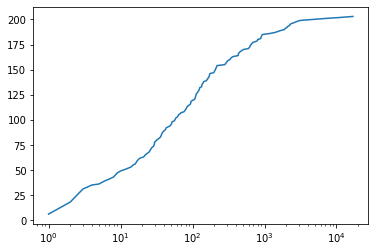

In [5]:
x, y = map(np.asarray, zip(*sorted(Counter(map(len, cat_vecs.values())).items())))
plt.semilogx(x, np.cumsum(y))

In [6]:
from itertools import count

pos2cat = []
cat2vec = np.zeros((len(cat_vecs), 50))
for i, (k, v) in enumerate(cat_vecs.items()):
    v = np.mean(v, axis=0)
    v /= np.linalg.norm(v)
    pos2cat.append(k)
    cat2vec[i] = v
cat2pos = {c:i for i, c in enumerate(pos2cat)}
pos2cat = np.asarray(pos2cat)

In [7]:
len([k for k, v in cat_vecs.items() if len(v) < 10])

47

In [8]:
infreq_cats = [k for k, v in cat_vecs.items() if len(v) < 10]

In [9]:
from random import choice
cat = choice(infreq_cats)
cat, len(cat_vecs[cat])

('1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4/85229bc745fa0b928fae43493f0e1b7880732410e3e6dc8422e15b2bf8383ee4/f799512e75c65fd48a6f5623fa0546ce00e4d0e491079973f10d578a8d98c150',
 3)

In [10]:
cat = cat.split('/')
for i, c in enumerate(cat):
    subcat = '/'.join(cat[:i+1])
    print(subcat) 
    sims = cat2vec[cat2pos[subcat]].dot(cat2vec.T)
    sims_idxs = np.argsort(sims)[::-1]
    for idx in sims_idxs[1:10]:
        print('\t {:.02f} '.format(sims[idx]),pos2cat[idx])

1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4
	 0.97  1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4/2764e8b98f0d26d3607cd96aa4cacb90c1b91ef07f8634656b1aa1fa64f97123
	 0.93  1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4/2764e8b98f0d26d3607cd96aa4cacb90c1b91ef07f8634656b1aa1fa64f97123/27852152ef9c8a94430ff6111a86d08f956081bba2ccb9b7ed7fee0a4f339cce
	 0.80  f799512e75c65fd48a6f5623fa0546ce00e4d0e491079973f10d578a8d98c150/4d1925a10e990c08d3aacb9c5ef751cdbc092a67c79545714595ef28d968b689/27852152ef9c8a94430ff6111a86d08f956081bba2ccb9b7ed7fee0a4f339cce
	 0.80  1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4/2764e8b98f0d26d3607cd96aa4cacb90c1b91ef07f8634656b1aa1fa64f97123/34d653d365aef4ef8b0707e4ea6ba3a0e897b95ef3cb36149c9e9dc3ae4e47c2
	 0.69  f799512e75c65fd48a6f5623fa0546ce00e4d0e491079973f10d578a8d98c150/4d1925a10e990c08d3aacb9c5ef751cdbc092a67c79545714595ef28d968b689/fbad4ea48d194f4c8de6df71c2eb36082ec1dc2744440da852

In [18]:
pos2cat[np.argsort(cat2vec[cat2pos['/'.join(cat)]].dot(cat2vec.T))[::-1]][1:10]

array(['1764afa1f05ee0c655c2a48d9115ec00168d1a594f7f63ff6daca25ff569a3c4/85229bc745fa0b928fae43493f0e1b7880732410e3e6dc8422e15b2bf8383ee4',
       '06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/285f066ea7608b0ef28f21b6cb7660b95edbc1ebe09c783d824fa8d67cf4ade2/fbad4ea48d194f4c8de6df71c2eb36082ec1dc2744440da852917855efa84f9e',
       '06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/0e566c6d47aa4853858d8a965cc8ea5195fd23555364a4ac4f74074c5e6b7b87/7279e67dc98586a6003e64e56312b32c9ea54679af8f5ee61d5e35d24911bd49',
       '06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/1ae3458f98744956d24b35b736cf63505df00c6302973b61c6aa9ff2aa345004/e3447e7f87fba770a9b76becc824a63b77cea6b124575f30b73be589742fac70',
       '06fa312761d4b39e2f649781514ac69a4c1505c221fc463426d38a2de1679683/1a70f92b5613ca0a334f45f072b80754c744e991de0cd8f08bc9ebeef599d6aa/115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c420d5d535205b27f81',
       '4bc233e6ff353e76261e50f68e9da93b

In [19]:
cat_vecs = {k: np.mean(v, axis=0).astype('float32') for k, v in cat_vecs.items()}

In [21]:
with open(fs.join(path, 'cat_avg_desc_emb.pkl'), 'wb') as f:
    pkl.dump(cat_vecs, f, 2)


# Description & image embedding matrices

In [22]:
reason = Counter()
for prod_sku, prod in utils.sku_edb.items():
    for k in 'description_vector', 'image_vector', 'price_bucket', 'category_hash':
        reason[k] += not prod[k]


In [23]:
reason

Counter({'description_vector': 34436,
         'image_vector': 38016,
         'price_bucket': 34348,
         'category_hash': 34334})

In [24]:
from itertools import count
c = count(1)
sku_hash2int = defaultdict(lambda : next(c))

desc_emb = []
img_emb = []
price = []
cat_emb = []
discarded = []
for prod_sku, prod in utils.sku_edb.items():
    if not prod['description_vector'] or not prod['price_bucket'] or not prod['category_hash']:
#     if not prod['description_vector'] or not prod['image_vector'] or not prod['price_bucket'] or not prod['category_hash']:
        discarded.append(prod)
        continue
        
    sku_hash2int[prod_sku]
    desc_emb.append(json.loads(prod['description_vector']))
#     img_emb.append(json.loads(prod['image_vector']))
    price.append([float(prod['price_bucket'])])
    
    cat_emb.append(cat_vecs[prod['category_hash']])
    
    # prod2vec
#     try:
#         cat_emb.append(w2v.wv.get_vector(prod['category_hash']).tolist())
#     except KeyError:
#         cat_emb.append(w2v.wv.get_vector('inf').tolist())

sku_hash2int = dict(sku_hash2int)
# pad
desc_emb.insert(0, [0.] * len(desc_emb[0]))
# img_emb.insert(0, [0.] * len(desc_emb[0])) 
cat_emb.insert(0, [0.] * len(cat_emb[0]))
price.insert(0, [0.]) 

In [25]:
len(discarded)

34442

In [26]:
from random import sample
sample(discarded, 10)

[{'product_sku_hash': 'ec5318e0458fd9828943c03d8af4c292d4eb0b8ddceaf011b1dfcdb0ff76aca8',
  'description_vector': '',
  'category_hash': '',
  'image_vector': '',
  'price_bucket': ''},
 {'product_sku_hash': 'be0bd18304bc1910fee9a4ecf6578d680d5daccafdc20cda4d4450998bf75dc0',
  'description_vector': '',
  'category_hash': '',
  'image_vector': '',
  'price_bucket': ''},
 {'product_sku_hash': '942af7911878718ed0587eba714957e725f6dee36ec4aab3d62a1be4553088fe',
  'description_vector': '',
  'category_hash': '',
  'image_vector': '',
  'price_bucket': ''},
 {'product_sku_hash': '8d0cf8b104d8424dcc97dc5c8aa1fc435d5382e7826eccf8f02cd152b6a503a6',
  'description_vector': '',
  'category_hash': '',
  'image_vector': '',
  'price_bucket': ''},
 {'product_sku_hash': '22dce739b3ff085afef2184f0f820e64b5574af897332b9e4ca0cffe69132705',
  'description_vector': '',
  'category_hash': '',
  'image_vector': '',
  'price_bucket': ''},
 {'product_sku_hash': 'e93add970abd344bcd70f74b6f7928a2ca8c4311504ce53

In [27]:
len(sku_hash2int), len(img_emb), len(desc_emb), len(price), len(cat_emb)

(31944, 0, 31945, 31945, 31945)

In [28]:
l = list(islice(utils.sku_edb.items(), 100))

In [29]:
sku_hash, sku_dict = l[-1]

In [30]:
assert json.loads(sku_dict['description_vector']) == desc_emb[sku_hash2int[sku_hash]]

In [113]:
with open(fs.join(path, 'sku_embeddings_avg_desc.pkl'), 'wb') as f:
    pkl.dump(dict(sku_hash2int=sku_hash2int, img=img_emb, descr=desc_emb, price=price, cat=cat_emb), f, 2)

In [31]:
cat_emb[sku_hash2int[sku_hash]] == cat_vecs[sku_dict['category_hash']]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [32]:
sku_hash

'00622c8d57726f4c9cc09409ce2675ca402f362cd322f662d03a392c31778b39'

# Encoding del pre-train data set

In [36]:
with open(fs.join(path, 'sku_embeddings_avg_desc.pkl'), 'rb') as f:
    d = pkl.load(f)

sku_hash2int = d['sku_hash2int']

In [37]:
from datetime import datetime
split_date = datetime(2019, 3, 20)

In [39]:
from core.serialization import JlWriter

tr_writer = JlWriter(fs.join(path, 'tr_encoded_data_v2.jl'))
te_writer = JlWriter(fs.join(path, 'te_encoded_data_v2.jl'))
for sess in progress(utils.iter_split(utils.iter_browsed(enrich=False), split_by=['add', 'purchase'], allowed_prod_acts=['detail', 'add', 'purchase'])):
    sess = [
        e
        for e in sess 
        if e['product_sku_hash'] in sku_hash2int
    ]
    if len(sess) < 2: continue
        
    # Si la sesion toca el test set, es parte del test set
    # Las sesiones de train, empiezan y terminan en train
    if datetime.fromtimestamp(sess[-1]['server_timestamp_epoch_ms'] / 1000) >= split_date:
        writer = te_writer
    else:
        writer = tr_writer
        
    sess = [
        dict(sku_id=sku_hash2int[e['product_sku_hash']], product_action=e['product_action']) 
        for e in sess 
    ]

    writer.write_doc(sess)
    
tr_writer.finish()
te_writer.finish()

2022-09-23 13:48:55 pid 30328 | starting to iterate, updating every 1 seconds
2022-09-23 13:48:57 pid 30328 | 27410, speed: 18803.15 it/s, elapsed 1.46 seconds
2022-09-23 13:48:58 pid 30328 | 46108, speed: 18699.31 it/s, elapsed 2.47 seconds
2022-09-23 13:48:59 pid 30328 | 63920, speed: 18419.76 it/s, elapsed 3.47 seconds
2022-09-23 13:49:00 pid 30328 | 80792, speed: 18073.31 it/s, elapsed 4.47 seconds
2022-09-23 13:49:01 pid 30328 | 99538, speed: 18196.10 it/s, elapsed 5.47 seconds
2022-09-23 13:49:02 pid 30328 | 115462, speed: 17791.68 it/s, elapsed 6.49 seconds
2022-09-23 13:49:03 pid 30328 | 131157, speed: 17511.71 it/s, elapsed 7.49 seconds
2022-09-23 13:49:04 pid 30328 | 145748, speed: 17159.87 it/s, elapsed 8.49 seconds
2022-09-23 13:49:05 pid 30328 | 162900, speed: 17159.02 it/s, elapsed 9.49 seconds
2022-09-23 13:49:05 pid 30328 | print interval is now 5s
2022-09-23 13:49:10 pid 30328 | 257520, speed: 17767.89 it/s, elapsed 14.49 seconds
2022-09-23 13:49:15 pid 30328 | 345337,

**TODO** comparar la distribucion de longitudes con las sesiones de meli

In [41]:
data = list(iter_jl(fs.join(path, 'tr_encoded_data_v2.jl')))

(array([1033529.,  207730.,   70010.,   24249.,   16730.,    8902.,
           3851.,    3321.,    1895.,    1270.]),
 array([ 2. ,  5.7,  9.4, 13.1, 16.8, 20.5, 24.2, 27.9, 31.6, 35.3, 39. ]),
 <BarContainer object of 10 artists>)

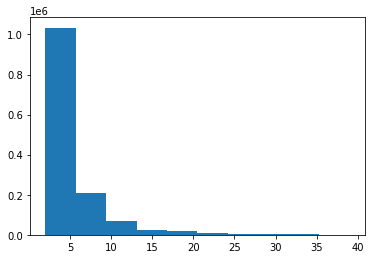

In [42]:
plt.hist([e for e in list(map(len, data)) if e < 40])

### Category prod2vec ?

In [1]:
sentences = []
for sess in progress(utils.iter_split(utils.iter_browsed(), split_by='purchase', allowed_prod_acts=['detail', 'purchase'])):
    categories = [e['prod']['category_hash'] for e in sess if e['prod']['category_hash']]
    sentences.append(categories)


In [276]:
['/'.join([utils.summarize_hash(h) for h in c.split('/')]) for c in sentences[1]]

['06fa9683/285fade2/7279bd49',
 '06fa9683/285fade2/7279bd49',
 '06fa9683/285fade2/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/285fade2/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49',
 '06fa9683/49d8b2ab/7279bd49']

In [72]:
from itertools import chain
cat_distr = Counter(chain(*sentences))

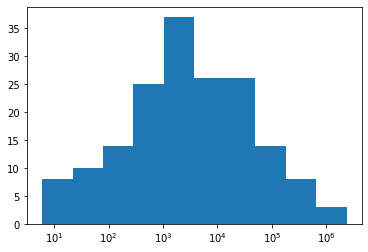

In [73]:
plt.hist(list(map(np.log10, cat_distr.values())))
plt.xticks(range(1, 7), [f'$10^{i}$' for i in range(1, 7)]);

In [74]:
len([v for k, v in cat_distr.items() if v > 100])

151

In [75]:
post_processed_sentences = [[c if cat_distr[c] > 100 else 'inf' for c in s] for s in sentences]

In [76]:
from gensim.models import Word2Vec
w2v = Word2Vec(post_processed_sentences, size=30, )

In [90]:
from random import choice

categ = choice(list(w2v.wv.vocab.keys()))
'/'.join(utils.summarize_hash(h) for h in categ.split('/'))

'06fa9683/f81a0eb6/7279bd49'

In [91]:
[('/'.join(utils.summarize_hash(h) for h in c.split('/')), v) for c, v in w2v.wv.most_similar(categ)]

[('06fa9683/f81a0eb6/f799c150', 0.6273624300956726),
 ('06fa9683/f81a0eb6/ff3bf3a9', 0.5973688364028931),
 ('06fa9683/f81a0eb6/284970f6', 0.5907426476478577),
 ('06fa9683/f81a0eb6/c9074b1d', 0.5876540541648865),
 ('06fa9683/48c09d13/f799c150', 0.5837746858596802),
 ('06fa9683/f81a0eb6', 0.5445898771286011),
 ('06fa9683/6fa99dfd/dd613d35', 0.5247635245323181),
 ('f799c150/4d19b689/25522fbf', 0.5242652297019958),
 ('06fa9683/48c09d13/ff3bf3a9', 0.5147247910499573),
 ('1764a3c4/27647123/34d647c2', 0.5138662457466125)]

**makes sense to represent categories**